# European Soccer Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
    <ul>
    <li><a href="#general">General Properties</a></li>
    <li><a href="#cleaning">Data Cleaning</a></li>
    </ul>
    <ul></ul>
<li><a href="#eda">Exploratory Data Analysis</a></li>
    <ul>
    <li><a href="#teams">Teams Distribution</a></li>
    <li><a href="#effectivityVSgoals_scored">Teams' Effectivity Correlation to Scored Goals</a></li>
    <li><a href="#effectivityVSgoals_recv">Teams' Effectivity Correlation to Received Goals</a></li>
    <li><a href="#home_away_goals">Home and Away Goals</a></li>
    <li><a href="#scored_recv_goals">Scored and Recv Goals</a></li>
    <li><a href="#home_win">Home and Away Goals</a></li>
    <li><a href="#leagues">Leagues Performance</a></li> 
    </ul>
    <ul></ul>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#limitations">Limitations on Analysis</a></li>
</ul>


<a id='intro'></a>
## Introduction

The dataset analyzed in this notebook is related to european football soccer teams matches. The dataset is provided in the format of an **SQLite database on Kaggle** and can be found [here](https://www.kaggle.com/hugomathien/soccer/data). If you are insterested in following along the first section of data wrangling demo for sqlite3 usage, please download the database in the same folder of the notebook and name it **soccer_db.sqlite**.

The analysis of this data involved SQL queries using [DB Browser](http://sqlitebrowser.org/). 

### **Data Analysis Motivation**

The purpose of this analysis is to use data from:
* England Premier League
* Spain LIGA BBVA
* Germany 1. Bundesliga
* Italy Serie A
* France Ligue 1
* Netherlands Eredivisie

with the purpose of understanding what the distribution of the teams performance over all seasons is.

Once the performance of every team is computed and the distribution is plotted, it will be good to find out if scoring more goals correlates to the performance of a team. While doing the previous it is also an opportunity to analyze if receiving less or more goals is also correlated to performance. 

The next mistery to unveil is the intriguing belief that when a team plays at home usually wins, while playing away gives the team less chance to win. 


Finally, it will be great to compare the leagues and check which league has a better average performance which is computed by averaging the teams performance in a given league. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from mpl_toolkits.mplot3d import Axes3D #for 3D plots

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

The data at first was loaded using *Python sqlite3* package, which helps stablish a connection to the database, then pandas is used to query, store, clean up and analysis of data. An example using the **soccer_db.sqlite** database is given to illustrate how to use the described above and to verify the leagues we are interested exist in the database.
However, the final query that merges joins, Common Table Expressions (CTE)and does math operations to the joined tables was very long and had to be processed in DB browser. The resulting table was saved as **teams_rank.csv** file to be able to load it on a pandas dataframe. 


<a id='general'></a>
### General Properties

The database used contains 8 tables:
* Country - All countries from which their teams data was collected
* League - All football leagues in the database
* Match - All games played in the different leagues
* Player - All players biometrics 
* Player_Attributes - All players and their statistics based on FIFA
* Team -  All team names
* Team_Attributes - Teams' statistics
* sqlite_sequence - sequence of the previous tables

Getting started with the analysis, I would like to show the use of sqlite3 and pandas, we need to connect to the SQLite database and find if the leagues we are interested exist in the current database.

>**Note:** Due to the complexity of the final query we use DB Browser, but this serves as a good section to learn a new tool to your belt.

In [2]:
#Stablish SQL connection and pandas for SQL query execution
conn = sqlite3.connect("soccer_db.sqlite")

#Query database to check and retrieve the leagues we are interested on
df_test = pd.read_sql_query("SELECT * \
                              FROM League\
                              WHERE name LIKE 'England%Premier%'\
                                    OR name LIKE 'Spain%BBVA%'\
                                    OR name LIKE 'Italy%'\
                                    OR name LIKE 'Germany%'\
                                    OR name LIKE 'France%'\
                                    OR name LIKE 'Netherlands%';"\
                            , conn)
df_test



,id,country_id,name
0,1729,1729,England Premier League
1,4769,4769,France Ligue 1
2,7809,7809,Germany 1. Bundesliga
3,10257,10257,Italy Serie A
4,13274,13274,Netherlands Eredivisie
5,21518,21518,Spain LIGA BBVA


Once the database was used and we confirmed the leagues we are interested exist on the database, the connection can be closed. 
**NOTE:** We only close the connection because from here on we have already collected the data in a csv file to help the user follow better and able to skip this sqlite part if needed.

In [3]:
#Close connection to database opened
conn.close()

Since all leagues exist, we can extract the data in a combined table to have all teams listed by a performance in descending order.  

**The Match table** has:
* League id and teams id, so we needs to perform the join with Team to understand which teams played
* Contains the season in which the match was played. The season are from 2008 to 2015. We are mainly interested in the overall performance of teams over these all season, therefore we are looking for a table that combines evything and not broken by seasons. 

>**Note:**The information above is important to mention in case someone else wants to use the same database for season analysis.


<a id='cleaning'></a>
### Data Cleaning

The steps followed in the SQL data preparation and cleaning are:

1. Join the tables League, Match and Team to understand the data
    
2. From the data on the join above create a new temporary table (CTE) that perfoms aggregations to create the league season results including season, team, total points, wins, losses, draws, home wins, home loses, home draws, away wins, away loses, away draws, home goals, away goals, total goals, home goals received, away goals received, total goals received, goals difference - *This table is league_results*

3. The table *league_results* can help us create a new table that consolidates results for each team over all seasons. In this step is when we should remember our questions to make the table contain what we need:

    * What is the distribution of the teams performance?
    * Is scoring more goals related to better performance?
    * Is receiving goals correlated to better performance?
    * Is playing home related to more wins?
    * Describe the performance of each league
  
4. Some data manipulation is needed to check each league over all seasons. However, this can be done in pandas with the table gotten from SQL

>**Note:** Something to highlight here that caught my attention is that the data was ready to use for answering the questions proposed above. The only caveat was that the total number of matches in each league could vary and we needed to consider proporction and averages to do our analysis instead of using the raw values from **SUM( )** or **AVG( )** from aggregations as they won't be fair for leagues or teams which had less matches. Besides that the data was clean enough to use it

To create a table with all the historical data from the desired leagues, use the query below:

>**Note:** The query below does step 1 and 2. The output of this query is what we describe in 3 as a table to help us answer our questions

``` mysql
WITH league_table AS ( 
                       SELECT 
                            l.id AS league_id,
                            t.team_api_id AS team_id,
                            l.name AS league,
							m.season AS season,
							t.team_long_name AS team,
							SUM(CASE  WHEN (m.home_team_api_id = t.team_api_id 
                                           AND m.home_team_goal - m.away_team_goal >= 1) 
                                           THEN 1 
                                       ELSE 0 
                                 END) AS HomeWins,
							
                            SUM(CASE WHEN (m.home_team_api_id = t.team_api_id  
                                          AND m.home_team_goal = m.away_team_goal) 
                                          THEN 1 
                                      ELSE 0 
                                 END) AS HomeDraws,
                                 
							SUM(CASE WHEN (m.home_team_api_id = t.team_api_id 
                                          AND m.home_team_goal - m.away_team_goal < 0) 
                                          THEN 1 
                                      ELSE 0 
                                 END) AS HomeLoses,
                                 
							SUM(CASE WHEN (m.away_team_api_id = t.team_api_id 
                                          AND m.away_team_goal - m.home_team_goal >=1 ) 
                                          THEN 1 
                                      ELSE 0 
                                 END) AS AwayWins,
                                 
							SUM(CASE WHEN (m.away_team_api_id = t.team_api_id 
                                          AND m.away_team_goal = m.home_team_goal) 
                                          THEN 1 
                                      ELSE 0 
                                 END) AS AwayDraws,
                                 
							SUM(CASE WHEN (m.away_team_api_id = t.team_api_id 
                                          AND m.away_team_goal - m.home_team_goal < 0) 
                                          THEN 1 
                                      ELSE 0 
                                 END) AS AwayLoses,
                                 
							SUM(CASE WHEN m.home_team_api_id = t.team_api_id 
                                            THEN m.home_team_goal END ) AS HomeGoals,
                                            
							SUM(CASE WHEN m.home_team_api_id = t.team_api_id 
                                            THEN m.away_team_goal END ) 
                            AS HomeGoalsConceded,
							
                            SUM(CASE WHEN m.away_team_api_id = t.team_api_id 
                                            THEN m.away_team_goal END ) AS AwayGoals,
							SUM(CASE WHEN m.away_team_api_id = t.team_api_id 
                                            THEN m.home_team_goal END ) 
                            AS AwayGoalsConceded	
							
                            FROM League l
							JOIN Match m
                                ON l.id = m.league_id
							JOIN Team t
                                ON m.home_team_api_id = t.team_api_id  
                                    OR m.away_team_api_id = t.team_api_id
							WHERE l.name LIKE 'England%' 
                                  OR l.name LIKE 'Spain%' 
                                  OR l.name LIKE 'Italy%' 
                                  OR l.name LIKE 'Germany%'
                                  OR l.name LIKE 'France%'
                                  OR l.name LIKE 'Netherlands%'
							GROUP BY l.name, m.season, t.team_long_name
							ORDER BY m.season, HomeWins DESC, AwayWins DESC 
			),
			
			league_results AS (			
								SELECT 
                                    league_id,
                                    team_id,
									league,
									season,
									team,
									(HomeWins + AwayWins)*3 
                                        + (HomeDraws + AwayDraws) AS total_points,
									
                                    (HomeWins + AwayWins + HomeDraws 
                                        + AwayDraws + HomeLoses + AwayLoses) 
                                    AS total_matches,
									
                                    (HomeWins + AwayWins) AS win,
									(HomeDraws + AwayDraws)  AS draw,
									(HomeLoses + AwayLoses) AS lose,
									(HomeGoals + AwayGoals) AS total_goals,
									(HomeGoalsConceded 
                                        + AwayGoalsConceded) AS total_goals_conceded,
									
                                    (HomeGoals + AwayGoals) 
                                        - (HomeGoalsConceded + AwayGoalsConceded)  
                                    AS goals_difference,
                                        
									(HomeWins + HomeDraws + HomeLoses) AS home_g,
									(AwayWins + AwayDraws + AwayLoses) AS away_g,
									HomeWins AS home_wins,
									HomeDraws AS home_draws,
									HomeLoses AS home_loses,
									AwayWins AS away_wins,
									AwayDraws AS away_draws,
									AwayLoses AS away_loses,
									HomeGoals AS home_goals,
									HomeGoalsConceded AS home_goals_conceded,
									AwayGoals AS away_goals,
									AwayGoalsConceded AS away_goals_conceded
								
                                FROM league_table
								ORDER BY season, total_points DESC 
			)
			
SELECT 
    league_id,
    team_id,
    league,
	team,
	SUM(total_points) AS total_points,
    
	100.0*SUM(win)/SUM(total_matches) + 100.0*SUM(draw)/SUM(total_matches) 
    AS overall_effectivity,
    
    100.0*SUM(lose)/SUM(total_matches) AS overall_ineffectuality,
    
    CAST(ROUND(1.0*SUM(total_points)/SUM(total_matches))AS INT) AS avg_points_per_match,
	SUM(total_matches) AS total_matches,

	SUM(win) AS total_wins,
	SUM(draw) AS total_draws,
	SUM(lose) AS total_loses,
	
	CAST( 100.0*SUM(win)/SUM(total_matches)  AS REAL) AS win_pct,
	CAST( 100.0*SUM(draw)/SUM(total_matches) AS REAL) AS draw_pct,
	CAST( 100.0*SUM(lose)/SUM(total_matches) AS REAL) AS lose_pct,
       
	SUM(total_goals) AS total_goals,
	SUM(total_goals_conceded) AS total_goals_conceded,
	SUM(goals_difference) AS total_goals_difference,
	
	SUM(total_goals)/SUM(total_matches) AS avg_goal_per_match,
	SUM(total_goals_conceded) /SUM(total_matches) AS avg_goal_against_per_match,
	
	SUM(home_g) AS home,
	SUM(away_g) AS away,
	SUM(home_wins) AS total_home_wins,
	SUM(home_draws) AS total_home_draws,
	SUM(home_loses) AS total_home_loses,
	SUM(away_wins) AS total_away_wins,
	SUM(away_draws) AS total_away_draws,
	SUM(away_loses) AS total_away_loses,
	
	CAST( 100.0*SUM(home_wins)/SUM(win) AS REAL) AS avg_home_win,
	CAST( 100.0*SUM(home_draws)/SUM(draw) AS REAL) AS avg_home_draw,
	CAST( 100.0*SUM(home_loses)/SUM(lose) AS REAL) AS avg_home_lose,
	
	CAST( 100.0*SUM(away_wins)/SUM(win) AS REAL) AS avg_away_win,
	CAST( 100.0*SUM(away_draws)/SUM(draw) AS REAL) AS avg_away_draw,
	CAST( 100.0*SUM(away_loses)/SUM(lose) AS REAL) AS avg_away_lose,
	
	CAST( 100.0*SUM(home_wins)/SUM(home_g) AS REAL) AS prop_home_win,
	CAST( 100.0*SUM(away_wins)/SUM(away_g) AS REAL) AS prop_away_win,
	
	CAST( 100.0*SUM(home_draws)/SUM(home_g) AS REAL) AS prop_home_draw,
	CAST( 100.0*SUM(away_draws)/SUM(away_g) AS REAL) AS prop_away_draw,
	
	CAST( 100.0*SUM(home_loses)/SUM(home_g) AS REAL) AS prop_home_lose,
	CAST( 100.0*SUM(away_loses)/SUM(away_g) AS REAL) AS prop_away_lose,
	
	SUM(home_goals) AS total_home_goals,
	SUM(home_goals_conceded) AS total_home_goals_conceded,
	SUM(away_goals) AS total_away_goals,
	SUM(away_goals_conceded) AS total_away_goals_conceded,
	
	
	100.0*SUM(home_goals)/SUM(total_goals) AS prop_home_goals,
	100.0*SUM(away_goals)/SUM(total_goals) AS prop_away_goals,
	100.0*SUM(home_goals_conceded)/SUM(total_goals_conceded) AS prop_home_goals_recv,
	100.0*SUM(away_goals_conceded)/SUM(total_goals_conceded) AS prop_away_goals_recv,
	
	ROUND(1.0*SUM(home_goals)/SUM(total_matches) )AS avg_home_goals_per_match,
	ROUND(1.0*SUM(away_goals)/SUM(total_matches) )AS avg_away_goals_per_match
		
FROM league_results
GROUP BY team
ORDER BY overall_effectivity DESC, total_points DESC, total_goals_difference DESC
```

#### Teams Rank

In order to make it easier for anyone to follow the notebook, the table has been saved as [**teams_rank.csv**](./teams_rank.csv) and one can load it using pandas

In [4]:
#path where our csv file exists
path = './data/'

#csv file
file = 'teams_rank.csv'

#Retrieving the data from our csv file
df_teams = pd.read_csv(path+file)

#Shows top 10 teams from all leagues
df_teams.head(10)

,league_id,team_id,league,team,total_points,overall_effectivity,overall_ineffectuality,avg_points_per_match,total_matches,total_wins,...,total_home_goals,total_home_goals_conceded,total_away_goals,total_away_goals_conceded,prop_home_goals,prop_away_goals,prop_home_goals_recv,prop_away_goals_recv,avg_home_goals_per_match,avg_away_goals_per_match
0,21518,8634,Spain LIGA BBVA,FC Barcelona,745,91.118421,8.881579,2,304,234,...,495,101,354,131,58.303887,41.696113,43.534483,56.465517,2.0,1.0
1,13274,8593,Netherlands Eredivisie,Ajax,602,88.235294,11.764706,2,272,181,...,360,78,287,158,55.641422,44.358578,33.050847,66.949153,1.0,1.0
2,7809,9823,Germany 1. Bundesliga,FC Bayern Munich,623,87.132353,12.867647,2,272,193,...,382,96,271,115,58.499234,41.500766,45.497630,54.502370,1.0,1.0
3,21518,8633,Spain LIGA BBVA,Real Madrid CF,720,86.842105,13.157895,2,304,228,...,505,147,338,157,59.905101,40.094899,48.355263,51.644737,2.0,1.0
4,10257,9885,Italy Serie A,Juventus,633,84.717608,15.282392,2,301,189,...,307,124,236,126,56.537753,43.462247,49.600000,50.400000,1.0,1.0
5,13274,8640,Netherlands Eredivisie,PSV,581,82.720588,17.279412,2,272,178,...,370,126,282,168,56.748466,43.251534,42.857143,57.142857,1.0,1.0
6,4769,9847,France Ligue 1,Paris Saint-Germain,601,82.565789,17.434211,2,304,175,...,332,116,236,151,58.450704,41.549296,43.445693,56.554307,1.0,1.0
7,1729,10260,England Premier League,Manchester United,633,81.907895,18.092105,2,304,192,...,338,120,244,160,58.075601,41.924399,42.857143,57.142857,1.0,1.0
8,1729,8455,England Premier League,Chelsea,598,80.921053,19.078947,2,304,176,...,333,129,250,157,57.118353,42.881647,45.104895,54.895105,1.0,1.0
9,7809,9789,Germany 1. Bundesliga,Borussia Dortmund,533,80.514706,19.485294,2,272,157,...,298,112,253,170,54.083485,45.916515,39.716312,60.283688,1.0,1.0


As one can see the query was able to compute the results of all teams from 2008 until 2015 seasons.

The top 10 teams displayed above are determined based on cummulative statistics and sorted by their overall effectivity, which is the percentage a team wins/draws a game out of all the games played until the last match provided in our dataset.

In [5]:
#Number of teams in our dataset
print('The data we will analyze includes {} teams'.format(df_teams.shape[0]))

The data we will analyze includes 189 teams


The above line tell us that we have 189 teams.

#### Performance of leagues

Once we extracted the teams' statistics over all season, we can compute the performance of each league doing an average on all the teams that belong to the league.

This is a perfect task for pandas and the groupby and mean methods which will helps us gather all teams from a league and average their statistics to compute the league statistics.

In [6]:
#Grouping our dataset by League in which each team plays and
# perform and average with all teams that belong to such league
df_leagues = df_teams.groupby('league').mean()
df_leagues.sort_values(by='overall_effectivity', ascending=False, inplace=True)

#No need an average ID of teams and league as this are unique for each, drop such columns
df_leagues.drop(['league_id','team_id'], axis=1, inplace=True)
df_leagues

,total_points,overall_effectivity,overall_ineffectuality,avg_points_per_match,total_matches,total_wins,total_draws,total_loses,win_pct,draw_pct,...,total_home_goals,total_home_goals_conceded,total_away_goals,total_away_goals_conceded,prop_home_goals,prop_away_goals,prop_home_goals_recv,prop_away_goals_recv,avg_home_goals_per_match,avg_away_goals_per_match
league,,,,,,,,,,,,,,,,,,,,,
France Ligue 1,236.028571,58.512710,41.487290,1.171429,173.714286,62.314286,49.085714,62.314286,30.779270,27.733441,...,121.857143,90.342857,90.342857,121.857143,58.330381,41.669619,43.390985,56.609015,0.914286,0.371429
England Premier League,245.205882,58.224421,41.775579,1.235294,178.823529,66.382353,46.058824,66.382353,32.601817,25.622604,...,138.676471,103.676471,103.676471,138.676471,56.787461,43.212539,42.891962,57.108038,0.970588,0.529412
Italy Serie A,257.968750,57.921813,42.078187,1.218750,188.562500,69.406250,49.750000,69.406250,31.370972,26.550840,...,141.500000,105.218750,105.218750,141.500000,57.700007,42.299993,42.794959,57.205041,0.875000,0.406250
Netherlands Eredivisie,270.520000,57.289216,42.710784,1.200000,195.840000,74.680000,46.480000,74.680000,33.686275,23.602941,...,174.280000,127.400000,127.400000,174.280000,58.942504,41.057496,42.048914,57.951086,0.960000,0.640000
Spain LIGA BBVA,255.030303,56.912641,43.087359,1.181818,184.242424,70.787879,42.666667,70.787879,33.450957,23.461685,...,150.272727,104.636364,104.636364,150.272727,58.255259,41.744741,41.178577,58.821423,0.969697,0.454545
Germany 1. Bundesliga,224.900000,56.813842,43.186158,1.166667,163.200000,61.700000,39.800000,61.700000,31.686158,25.127684,...,132.733333,104.033333,104.033333,132.733333,56.165352,43.834648,45.336792,54.663208,0.900000,0.666667


At this point we have all the data needed and we have even gone beyond and done some descriptive statistics to our current values. However, before we proceed, it will be a good idea to have a single table in which we add the league performance/effectivity to all our results

In [7]:
#Retrieving only the mean total goals and effectivity of each league
df_league_eff = df_leagues[['overall_effectivity','total_goals']].copy()

#Rename the columns to prefix them with 'league_' and move league to be a column and not an index
df_league_eff.rename(columns={'overall_effectivity':'league_overall_effectivity',
                              'total_goals':'league_total_goals'},
                                 inplace=True)
df_league_eff.reset_index(level=0,inplace=True)
df_league_eff

,league,league_overall_effectivity,league_total_goals
0,France Ligue 1,58.512710,212.200000
1,England Premier League,58.224421,242.352941
2,Italy Serie A,57.921813,246.718750
3,Netherlands Eredivisie,57.289216,301.680000
4,Spain LIGA BBVA,56.912641,254.909091
5,Germany 1. Bundesliga,56.813842,236.766667


In [8]:
#Merge the previous dataframe with each league information into our original dataframe which includes all teams
df_all = pd.merge( left=df_teams, right=df_league_eff, on='league')
df_all.sort_values(by='overall_effectivity', ascending=False, inplace=True)
df_all.reset_index(drop=True,inplace=True)
df_all.head(10)

,league_id,team_id,league,team,total_points,overall_effectivity,overall_ineffectuality,avg_points_per_match,total_matches,total_wins,...,total_away_goals,total_away_goals_conceded,prop_home_goals,prop_away_goals,prop_home_goals_recv,prop_away_goals_recv,avg_home_goals_per_match,avg_away_goals_per_match,league_overall_effectivity,league_total_goals
0,21518,8634,Spain LIGA BBVA,FC Barcelona,745,91.118421,8.881579,2,304,234,...,354,131,58.303887,41.696113,43.534483,56.465517,2.0,1.0,56.912641,254.909091
1,13274,8593,Netherlands Eredivisie,Ajax,602,88.235294,11.764706,2,272,181,...,287,158,55.641422,44.358578,33.050847,66.949153,1.0,1.0,57.289216,301.680000
2,7809,9823,Germany 1. Bundesliga,FC Bayern Munich,623,87.132353,12.867647,2,272,193,...,271,115,58.499234,41.500766,45.497630,54.502370,1.0,1.0,56.813842,236.766667
3,21518,8633,Spain LIGA BBVA,Real Madrid CF,720,86.842105,13.157895,2,304,228,...,338,157,59.905101,40.094899,48.355263,51.644737,2.0,1.0,56.912641,254.909091
4,10257,9885,Italy Serie A,Juventus,633,84.717608,15.282392,2,301,189,...,236,126,56.537753,43.462247,49.600000,50.400000,1.0,1.0,57.921813,246.718750
5,13274,8640,Netherlands Eredivisie,PSV,581,82.720588,17.279412,2,272,178,...,282,168,56.748466,43.251534,42.857143,57.142857,1.0,1.0,57.289216,301.680000
6,4769,9847,France Ligue 1,Paris Saint-Germain,601,82.565789,17.434211,2,304,175,...,236,151,58.450704,41.549296,43.445693,56.554307,1.0,1.0,58.512710,212.200000
7,1729,10260,England Premier League,Manchester United,633,81.907895,18.092105,2,304,192,...,244,160,58.075601,41.924399,42.857143,57.142857,1.0,1.0,58.224421,242.352941
8,1729,8455,England Premier League,Chelsea,598,80.921053,19.078947,2,304,176,...,250,157,57.118353,42.881647,45.104895,54.895105,1.0,1.0,58.224421,242.352941
9,7809,9789,Germany 1. Bundesliga,Borussia Dortmund,533,80.514706,19.485294,2,272,157,...,253,170,54.083485,45.916515,39.716312,60.283688,1.0,1.0,56.813842,236.766667


With the merge above we could add the league average effetivity to each row, so that a team depending on the league the belong can get the overall effectivity of their league.

This previous step makes us ready to explore our data and find insights from it to answer our questions later on and maybe dig in more into relations of league and teams.

<a id='eda'></a>
## Exploratory Data Analysis

In this section we will take advantage of our collected and cleaned data to understand the motivation of the analysis and the questions during <a href='#cleaning'>data cleaning</a>

<a id='teams'></a>
### Teams' Effectivity Distribution

The **overall_effectivity** column gives us the team effectivity. We can use this column to plot a histogram of all teams effectivity. It will also be a good idea to use a boxplot to find the quartiles, minimum, maximum and some outliers.

Mean: 57.65
Standard Dev: 12.13
Median: 56.58


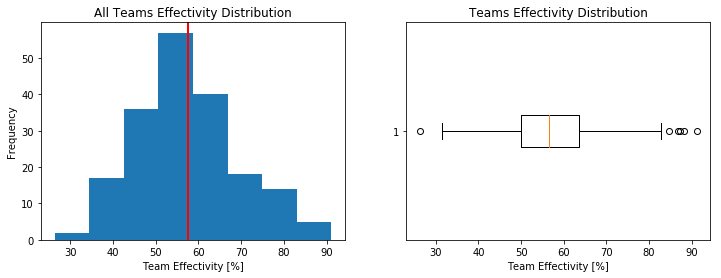

In [9]:
#Calculate mean, standard deviation and mean of teams' overall effectivity
mean_eff = df_all['overall_effectivity'].mean()
std_eff = df_all['overall_effectivity'].std()
median_eff = df_all['overall_effectivity'].median()
print('Mean: {:.2f}\nStandard Dev: {:.2f}\nMedian: {:.2f}'\
      .format(mean_eff, std_eff, median_eff))

#Plot teams effectivity histogram and boxplot to understand what kind of distribution it follows
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.axvline(mean_eff, color='r', linewidth=2)
plt.hist(df_all['overall_effectivity'], bins=8)
plt.xlabel('Team Effectivity [%]')
plt.ylabel('Frequency')
plt.title('All Teams Effectivity Distribution');

plt.subplot(1,2,2)
plt.boxplot(df_all['overall_effectivity'], vert=0)
plt.xlabel('Team Effectivity [%]')
plt.title('Teams Effectivity Distribution');

From the above we can see that the distribution of the teams effectivity is close to normal, but we are a little skewed to the right. This is caused by the outliers that we see on the boxplot. The interesting part is that most outliers are in the better effectivity side, meaning there are some star teams in our dataset and they must be part of the top 10 teams we showed above.

In addition, the standard deviation is 12.13% effectivity and the mean is 57.63% effectivity which means that average teams win/draw more than they lose.

If teams win/draw more to have a >50% effectivity, it will be interesting to check if scoring or receiving scores is related to the wins/draws.

<a id='effectivityVSgoals_scored'></a>
### Teams' Effectivity Correlation to Scored Goals

Here we try to visualize if there might be a correlation of effectivity and scored goals

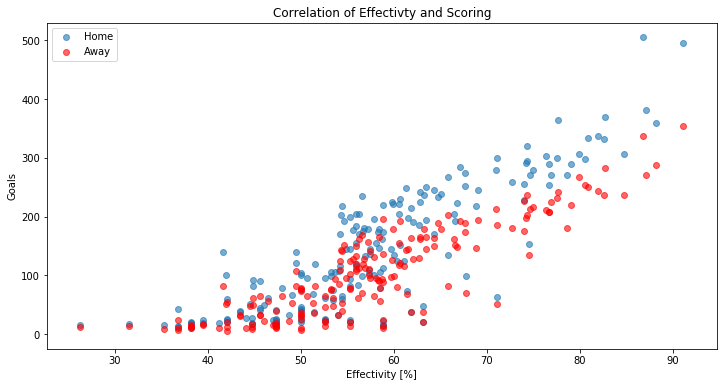

In [10]:
#Scatter plot of a team effectivity against the total goals at home and away
plt.figure(figsize=(12,6))
plt.scatter(x=df_all['overall_effectivity'],y=df_all['total_home_goals'], \
            alpha=0.6, label = 'Home')
plt.scatter(x=df_all['overall_effectivity'],y=df_all['total_away_goals'], \
            alpha=0.6, color='r', label = 'Away')
plt.xlabel('Effectivity [%]')
plt.ylabel('Goals')
plt.title('Correlation of Effectivty and Scoring')
plt.legend();

Based on the graph we noticed that there seem to be a positive correlation, so it will be nice to know the actual correlation coefficient to prove our idea true.

In [11]:
#Calculate pearson coefficient to verify if there is correlation between the chosen columns
df_all[['overall_effectivity','total_home_goals','total_away_goals']].corr('pearson')

,overall_effectivity,total_home_goals,total_away_goals
overall_effectivity,1.000000,0.857166,0.868547
total_home_goals,0.857166,1.000000,0.981976
total_away_goals,0.868547,0.981976,1.000000


The pearson coefficient shows us that effectivity is strongly correlated to the goals scored. 

>**Insight:** We found an interesting correlation. It seems that goals scored at home and goals scored away are even stronger correlated, meaning that there is a relationship with a team ascoring home versus away. This might be something interesting to check later on

<a id='effectivityVSgoals_recv'></a>
### Teams' Effectivity Correlation to Received Goals

After proving that the scored goals are related to effectivity, we would like to know if the goals received is also related to the effectivity. We will first visualize this in a scatter plot.

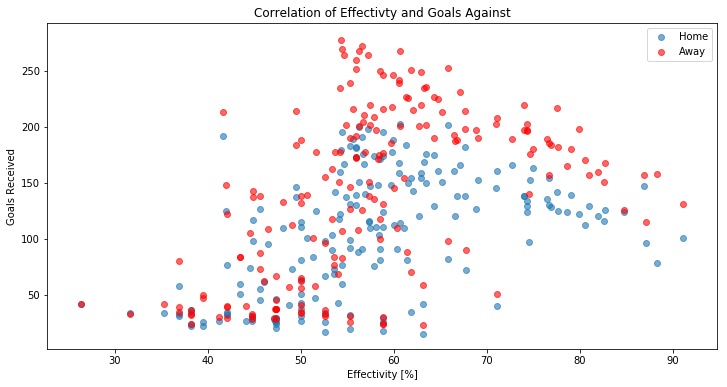

In [12]:
#Scatter plot of a team effectivity against the total goals conceded at home and away
plt.figure(figsize=(12,6))
plt.scatter(x=df_all['overall_effectivity'],y=df_all['total_home_goals_conceded']\
            , alpha=0.6, label='Home')
plt.scatter(x=df_all['overall_effectivity'],y=df_all['total_away_goals_conceded'],\
            alpha=0.6, color='r', label = 'Away')
plt.xlabel('Effectivity [%]')
plt.ylabel('Goals Received')
plt.title('Correlation of Effectivty and Goals Against')
plt.legend();

There seems to be no correlation, but to be entirely sure we can run a pearson coefficient showing a low value.

In [13]:
#Calculate pearson coefficient to verify if there is correlation between the chosen columns
df_all[['overall_effectivity','total_home_goals_conceded'\
        ,'total_away_goals_conceded']].corr('pearson')

,overall_effectivity,total_home_goals_conceded,total_away_goals_conceded
overall_effectivity,1.000000,0.478743,0.485431
total_home_goals_conceded,0.478743,1.000000,0.964019
total_away_goals_conceded,0.485431,0.964019,1.000000


The pearson coefficient confirmed our thoughts, but we found something interesting again.
The goals conceded home and away are correlated similar to the scored goals. This definitively is showing information we did not ask, but that is insightful.

As an exercise of curiosity, we can plot the effectivity, goals scored and received, home and away. Then we can mark the top teams and verify that our effectivity distribution is a little skewed, the goals scored home and away overlap and we have a big scatter plot thanks to the received goals.

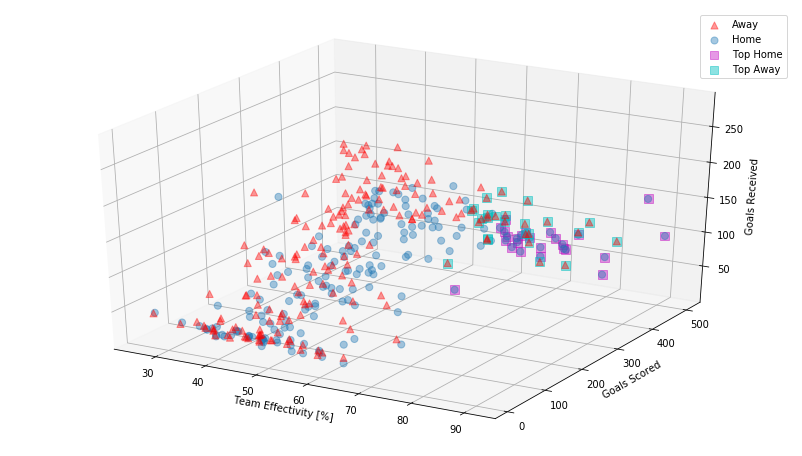

In [14]:
# 3D Scatter plot of a team effectivity against the total goals scored/conceded at home and away

# All teams plot
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=df_all['overall_effectivity'], ys=df_all['total_away_goals'], zs=df_all['total_away_goals_conceded'],\
            alpha=0.4, marker='^', color='r', label = 'Away',s=50)
ax.scatter(xs=df_all['overall_effectivity'], ys=df_all['total_home_goals'], zs=df_all['total_home_goals_conceded']\
            , alpha=0.4, marker='o', label='Home',s=50)

# Top 25 teams markers/identifiers
df_top25 = df_all.head(25)
ax.scatter(xs=df_top25['overall_effectivity'], ys=df_top25['total_home_goals'], zs=df_top25['total_home_goals_conceded'],\
            alpha=0.4, marker='s', color='m', label = 'Top Home', s=80)
ax.scatter(xs=df_top25['overall_effectivity'], ys=df_top25['total_away_goals'], zs=df_top25['total_away_goals_conceded'],\
            alpha=0.45, marker='s', color='c', label = 'Top Away', s=80)

ax.set_xlabel('Team Effectivity [%]')
ax.set_ylabel('Goals Scored')
ax.set_zlabel('Goals Received')

ax.legend();

The 3D plot help us distinguish what we were looking and we can also see the top teams have the correlation that the more they score the more effectivity they have.

<a id='home_away_goals'></a>
### Home and Away Goals are Correlated!

Thanks to our pearson coefficient calculations we found that:
* Goals Scored Home and Away are strongly correlated
* Goals Received Home and Away are strongly correlated

We can show this correlation in the following scatter plot

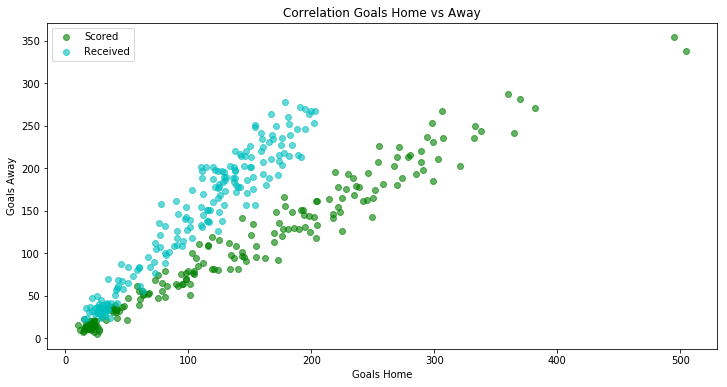

In [15]:
#Create a new figure
plt.figure(figsize=(12,6))

#Scatter plot of a team's total goals at home against away 
plt.scatter(x=df_all['total_home_goals'], y=df_all['total_away_goals'], alpha=0.6\
            , color='g', label = 'Scored')

#Scatter plot of a team's total goals conceded at home against away 
plt.scatter(x=df_all['total_home_goals_conceded'], y=df_all['total_away_goals_conceded']\
            , alpha=0.6, color='c', label = 'Received')

plt.title('Correlation Goals Home vs Away')
plt.xlabel('Goals Home')
plt.ylabel('Goals Away')
plt.legend();

In [16]:
#Calculate pearson coefficient to verify if there is correlation between the chosen columns
df_all[['total_home_goals','total_away_goals','total_home_goals_conceded'\
        ,'total_away_goals_conceded']].corr('pearson')

,total_home_goals,total_away_goals,total_home_goals_conceded,total_away_goals_conceded
total_home_goals,1.000000,0.981976,0.739852,0.736638
total_away_goals,0.981976,1.000000,0.733147,0.735996
total_home_goals_conceded,0.739852,0.733147,1.000000,0.964019
total_away_goals_conceded,0.736638,0.735996,0.964019,1.000000


As we expected it, goals scored (home and away) and goals received (home and away) are strongly correlated. This means that when a team scores more goals home it will tend to score more goals away. The same applies to the received goals. However the received goals have a greater slope which means they tend to be less than the scored goals.

<a id='scored_recv_goals'></a>
### Goals Scored correlate to Received Goals?

The next question we had was to know if scored goals correlate to received goals, adn we might be expectig somehow of a correlation thanks to our insight found.

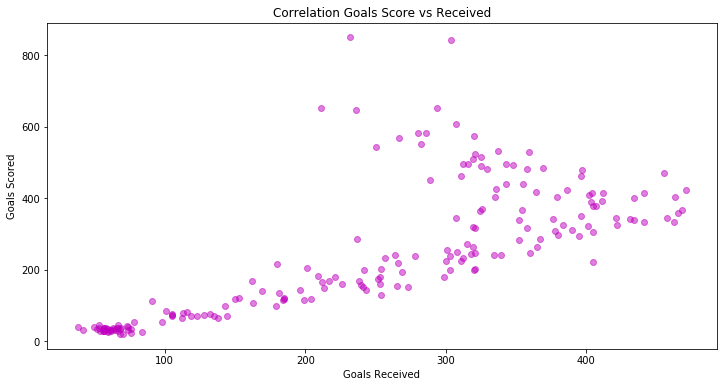

In [17]:
#Scatter plot of a team's total goals scored against total goals conceded 
plt.figure(figsize=(12,6))
plt.scatter(x=df_all['total_goals_conceded'],y=df_all['total_goals'], alpha=0.5, color='m');
plt.title('Correlation Goals Score vs Received')
plt.xlabel('Goals Received')
plt.ylabel('Goals Scored');

In [18]:
#Calculate pearson coefficient to verify if there is correlation between the chosen columns
df_all[['total_goals','total_goals_conceded']].corr('pearson')

,total_goals,total_goals_conceded
total_goals,1.000000,0.746472
total_goals_conceded,0.746472,1.000000


To our surprise the goals scored and received are somehow linearly correlated, but not as strong as we would have expected. This might be caused by the star teams as they tend to score more and receive less goals.

<a id='home_win'></a>
### Home Games and the Winning Factor

If you are a soccer fan you have heard fo the home winning factor because it is said that if a team plays home it tends to win. Here we will investigate this idea.

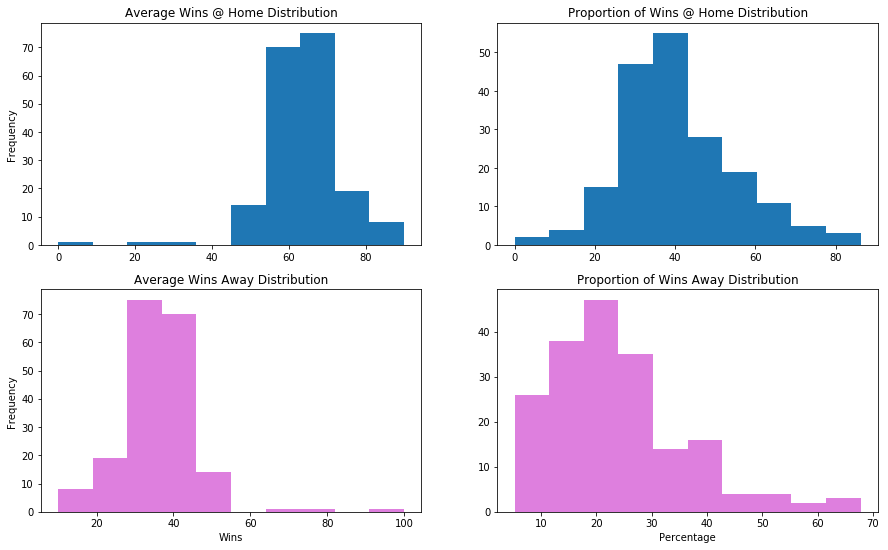

In [19]:
#Distribution of average victories at home and 
# the distribution of the proportion of victories of a team at home out of total games
plt.figure(figsize=(15,9))
plt.subplot(221)
plt.hist(df_all['avg_home_win'], bins=10 )
plt.title('Average Wins @ Home Distribution')
plt.ylabel('Frequency')
plt.subplot(222)
plt.hist(df_all['prop_home_win'], bins=10)
plt.title('Proportion of Wins @ Home Distribution')

#Distribution of average victories away and 
# the distribution of the proportion of victories of a team away out of total games
plt.subplot(223)
plt.hist(df_all['avg_away_win'], bins=10, color ='m', alpha=0.5 )
plt.title('Average Wins Away Distribution')
plt.xlabel('Wins')
plt.ylabel('Frequency')
plt.subplot(224)
plt.hist(df_all['prop_away_win'], bins=10, color ='m', alpha=0.5)
plt.title('Proportion of Wins Away Distribution')
plt.xlabel('Percentage');

There is something very interesting in this histograms. 

If a team plays away it tends to win less in average compared to the average victories at home.
The histogram of average victories away also matches with the distribution of the proportion of wins away histogram. This confirms that a team wins less when it plays away.

However, the most interesting graph comparison is between the average wins home and the proportion of wins at home. These show a shift in the data. Meaning that on average, teams tend to win more at home than away based on the blue upper left histogram, but the proportion of wins at home histogram shows that most teams only win 40% of their games played at home. This is a very interesting discovery.

All in all, we can confirm that the teams do actually perfom better at home since on averag they win more games home than away, and the majority of teams wins a higher porportion of their games at home.

To illustrate our conclusion even more we can also check if draws are more related to wins at home or away

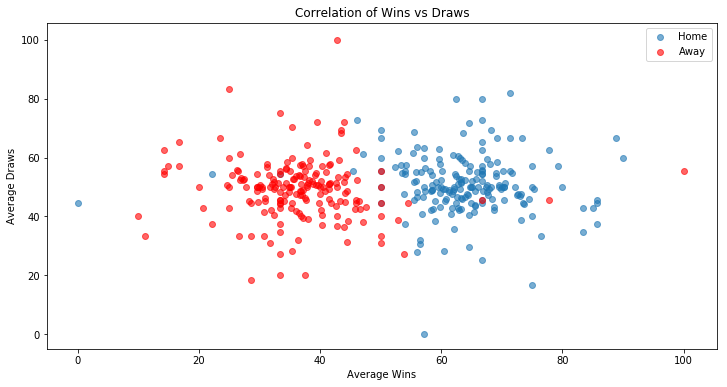

In [20]:
# Scatter plot of the average draws against the average victories
plt.figure(figsize=(12,6))
plt.scatter(x=df_all['avg_home_win'],y=df_all['avg_home_draw'],\
            alpha=0.6, label = 'Home')
plt.scatter(x=df_all['avg_away_win'],y=df_all['avg_away_draw'],\
            alpha=0.6, color='r', label = 'Away')
plt.title('Correlation of Wins vs Draws')
plt.xlabel('Average Wins')
plt.ylabel('Average Draws')
plt.legend();

With the scatter plot above we can confirm our thoughts on teams winning more at home and we can say draws are almost the same home or away.

<a id='leagues'></a>
### Leagues Performance

Finally, we want to analyze the performance of each league to understand which league has a better overall effectivity based on its teams. We had already displayed the dtaframe that contains all our information before starting our EDA.

The analysis to find that out is t first use boxplots of each league, then plot a bar chart to distinguish their heights and finally try to correlate each league performance to the total goals in each league

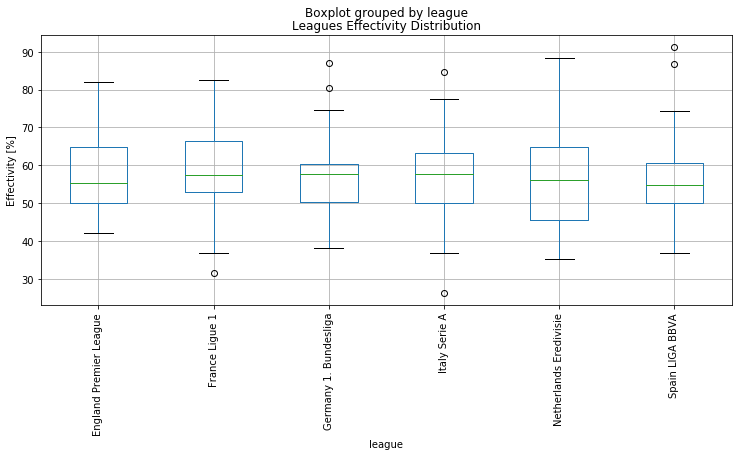

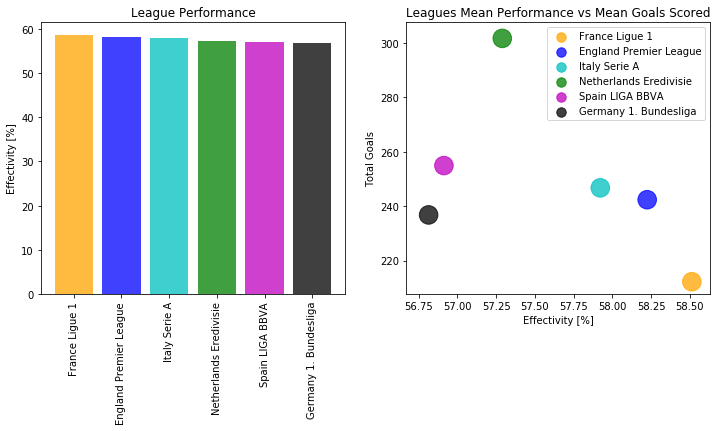

In [21]:
# BoxPlot of each league distribution of effectivity
df_all.boxplot(column='overall_effectivity', by='league', figsize=(12,5))
plt.ylabel('Effectivity [%]')
plt.xticks(rotation=90)
plt.title('Leagues Effectivity Distribution');

c = ['orange', 'blue', 'c', 'g','m','k'] 


# Bar plot of avg effectivity on each league
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.bar(range(df_leagues.shape[0]), df_leagues['overall_effectivity']\
        , alpha= 0.75, color=c )
plt.xticks(range(df_leagues.shape[0]),df_leagues.index, rotation=90)
plt.ylabel('Effectivity [%]')
plt.title('League Performance');

# Scatter plot effectivity vs total goals scored
plt.subplot(1,2,2)
labels = [l for l in df_leagues.index]
for i in range(df_leagues.shape[0]):
    plt.scatter(x=df_leagues.query('league == "{}"'.format(labels[i]))['overall_effectivity']
                , y=df_leagues.query('league == "{}"'.format(labels[i]))['total_goals']
                , alpha= 0.75, color= c[i]
                , s=2*df_leagues['total_matches'].astype(int)
                , label=labels[i]
                )

plt.legend(handletextpad=0.8, markerscale=0.5)
plt.ylabel('Total Goals')
plt.xlabel('Effectivity [%]')
plt.title('Leagues Mean Performance vs Mean Goals Scored');

The boxplot is the most useful from all our plots in this analysis as it also show outliers, but we should not ignore the other plots as they convey important information to complete our analysis.

1. France Ligue 1 seems to be the league with better performance, but it has less goals scored and it has a team that has a performance extremely low compared to the other teams in the league. This causes the distribution to have mean shifted to the left. All in all, this might be the most balanced league and that is the reason to have the highest average with less goals scored.

2. England Premier League is the second league based on performance, and the goals scored are close to other 3 leagues. The boxplot tells us that in this league there are no outliers and that there is a skew toward the positive performance (right). This means that in this league there are many good teams as 2 teams from this league (Manchester United, Chelsea) are part of the top 10 teams from all leagues, but they are not outliers in their league. They are only part of the right skew.

3. Italy Serie A is the third rank and right away the boxplot tell us that these league has a really bad team and an extremly good team. The good team is Juventus. Besides that we can see the distribution is close to normal, but a bit left skewed. However, it seems to be a balanced league and it has more goals than the previous two.

4. Netherlands Erdivisie shows the same exact behavior the Premier League did except for the fact that in this league we have the maximum number of goals and the most right skewed and widest distribution. However, there were no outliers marked. This tell us that in this league there are some top teams that score a lot when they win.

5. Spain Liga BBVA takes the fifth place with a very tight distribution very close to normal and with 2 outliers that we all know them: Real Madrid and Barcelona. These two teams outperform every other team in their league and Barcelona is the number 1 rank in all teams. Thus, we do expect this distribution to be a bit skewed. If we were to remove these 2 outperformers we will probably get a normal distribution.

6. Germany 1. Bundesliga takes the last place from all leagues performance, but the goals scored are very close to other leagues. This league just like Liga BBVA has two outperformers: Ajax and PSV. They are the resposibles of shifting the distribution.

Once we got the leagues distribution and analyzed that only total goals scored are related to a team effectivity, but not the goals received; curiosity drove me to check if there are clusters made beetween the league effectivity, team effectivity and goal difference.

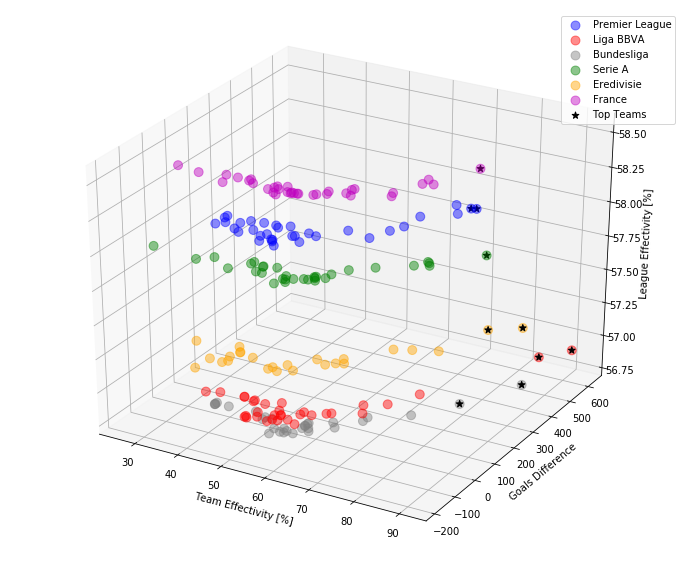

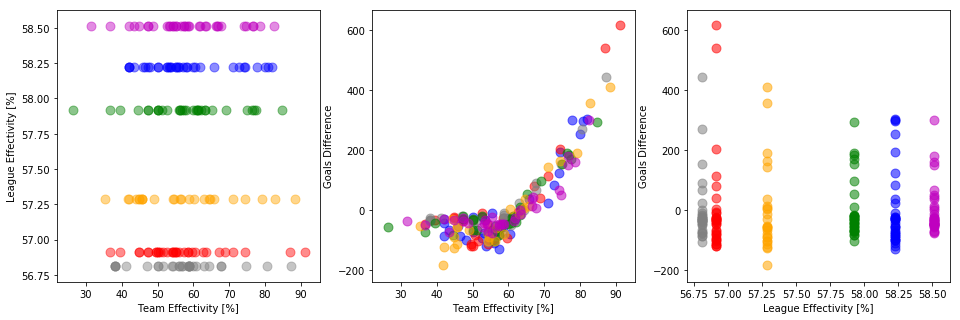

In [22]:
# 3D plot of league's clusters
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

query_str = ['league == "England Premier League"'
             ,'league == "Spain LIGA BBVA"'
             ,'league == "Germany 1. Bundesliga"'
             ,'league == "Italy Serie A"'
             ,'league == "Netherlands Eredivisie"'
             ,'league == "France Ligue 1"'
             ]

labels = ['Premier League'
         ,'Liga BBVA'
         ,'Bundesliga'
         ,'Serie A'
         ,'Eredivisie'
         ,'France']

c= ['b','r','gray','g','orange','m']

# Leagues clusters based on team's effectivity, league's effectivity of the team, team's total goals difference
for i in range(len(labels)):
    ax.scatter(xs=df_all.query(query_str[i])['overall_effectivity']\
            ,zs=df_all.query(query_str[i])['league_overall_effectivity']\
            ,ys=df_all.query(query_str[i])['total_goals_difference'], \
            alpha=0.45, label = labels[i], color = c[i], s=80)

#Top teams markers
df_top = df_all.head(10)
ax.scatter(xs=df_top['overall_effectivity']
           , ys=df_top['total_goals_difference']
           , zs=df_top['league_overall_effectivity']
           , alpha=1, marker='*', color='k'
           , label = 'Top Teams', s=50)

ax.set_zorder(len(labels))
ax.set_xlabel('Team Effectivity [%]')
ax.set_zlabel('League Effectivity [%]')
ax.set_ylabel('Goals Difference')


ax.legend();

#subplots that split up the 3D plot in different planes
fig = plt.figure(figsize=(16,5))

# Team's effectivity vs team's league's effectivity 
plt.subplot(1,3,1)
for i in range(len(labels)):
    plt.scatter(x=df_all.query(query_str[i])['overall_effectivity']\
            ,y=df_all.query(query_str[i])['league_overall_effectivity']\
            ,alpha=0.45, label = labels[i], color = c[i], s=80)

plt.xlabel('Team Effectivity [%]')
plt.ylabel('League Effectivity [%]')
 
# Team's effectivity vs total goals difference    
plt.subplot(1,3,2)
for i in range(len(labels)):
    plt.scatter(x=df_all.query(query_str[i])['overall_effectivity']\
            ,y=df_all.query(query_str[i])['total_goals_difference']\
            ,alpha=0.55, label = labels[i], color = c[i], s=80)

plt.xlabel('Team Effectivity [%]')
plt.ylabel('Goals Difference')
    
# Team's league's effectivity vs total goals difference
plt.subplot(1,3,3)
for i in range(len(labels)):
    plt.scatter(x=df_all.query(query_str[i])['league_overall_effectivity']\
            ,y=df_all.query(query_str[i])['total_goals_difference']\
            ,alpha=0.55, label = labels[i], color = c[i], s=80)

plt.xlabel('League Effectivity [%]')   
plt.ylabel('Goals Difference');

Mainly, I did this plot to show clusters from the data because leagues have different average performances, but teams have a similar effectivity as shown in the first distribution plotted. This leads to overlaps that we can see in the bottom middle subplot. Especially, our overlap is due to the difference in goals. We discovered that teams that peformed better scored more goals and must have won or draw the most. That doesn't necessarily meant the top teams goal difference will be higher than all other teams, but we hope that is the case as they kept winning and increasing their goals difference with positive numbers. This 3D plot shows exactly that and the most interesting part is that not necesarily a high positive goal difference makes a team the one with high effectivity. In other words, it is confirming that effectivity of teams depends more on scoring goals and not necessarily to receiving less goals.

<a id='conclusions'></a>
## Conclusions

The main conclusion we can make from the soccer data are:

* The **teams' effectivity distribution** is close to normal with a slight skewness to the right. However, if we were to get more leagues and plot a distrbution we might find it is actually normal and we just needed more teams as 189 teams (samples) might be a small set to determine this. In any case, I decided to calculate the mean, median and standard deviation of this distribution which are 57.65%, 56.58%  and 12.13% respectively. This tell us that the median being very close to the mean is a good sign of a distribution close to a normal distribution, but in this case it confirms our conclusion of having a slight right skewness.

* The **teams' effectivity is strongly correlated (positive) to how many goals a team scores** 

* The **teams' effectivity is weakly correlated (positive) to how many goals a team receives**

> From the two conclusions above we also discovered that the goals scored home and way is strongly correlated meaning that if a teams scores a lot at home, it tends to score away more goals as well. The same applies for goals received. If a team receives more goals at home it also tends to receive more goals away.

* The **home winning factor** was proven to be true after we analyzed histogram of proportion of wins home and away, avergae games won at hoem and away, and we made a scatter plot of draw vs wins home and away. These visualizations helped us realized that team on average win more at home although that doesn't mean all teams win at home. In fact, a little proportion of teams win most fo the games at home.

* Finally, the **league effectivity rank** we performed helped us to rank the leagues based on effectivity and it actually open many more questions that we didn't address here such as why a league is better than another? is it because a greater amount of better teams play there? what is a 'better team'? Are balanced leagues performing better? All in all, the conlusion we got from analyzing data for each league helped us realize that all these leagues have a very similar average effectivity and that the distribution are quite tight among the teams playing in each league. The top performers teams were easily seen as outliers in our plots, and we also determine that each league has its own characteristics, because th total goals varies. For example the Eredivisie has the most goals, and that can indicate there are better teams than the average and less team below the average, which our boxplot confirms. On the other side the League 1 has the best effectivity but the least amount of goals whihc tell us it most be a very balanced league in which teams either score a lot but end up in a draw or they win a lot and lose a lot. We can say that as the goal difference distribution of its teams is almost center around zero. We could containue making sense out of these plots for a long times, and more and more questions will continue to pop up. 


If there is a big take away from this analysis is realizing the truth behind the phrase:
 >"The worst team can beat the position 1 on the table team on a sunday match" 

Now, we can agree with that and stop beliving it is black magic. In fact, it is just that the lowest on the table teams of each league are actually not awful teams, they are in a decent standing within a distribution and might have an average effectivity below the average of the legaue, but that doesn't mean a zero chance to win. That is the beauty of football and we just proved by analyzing the leagues and teams.

<a id='limitations'></a>
## Limitations on Analysis

1. The first limitation described in conclusions is the size of our dataset. We only had 189 teams which each had a lot of data, but we needed to compacted it to have an overall performance and data over the year for all teams. The 189 samples seems a small number for a massive study of soccer in Europe. If we were able to get all teams in all leagues we might get different distributions or correlations as we found in here.

2. This dataset is only for European teams and only a small sample of all european soccer teams. The conclusions made here are valid only for the European leagues and maybe even narrower to only teh leagues we chose. This is due to the lack of a hypothesis testing or confidence interval statistics for our data.

3. The data used is from 2008 to 2015 which means that if we want to make predictions of 2016 to 2018 we will be out of the time we analyzed and we do not know if the behavior, distributions of the soccer matches and teams have changed. It is not recommended to predict anything with out data unless we use more advance techniques such as machine learning and predictive algorithms.

4. The effectivity of each team and the league were calculated based on the win and draw games, meaning that the variables of goals difference/scored/received were not taken into account. This limits us to only say a team is better than another based on its rating on less matches lost. Someone might be more interested in getting and effectivity considering more variables and that is valid. For the purpose of thsi analysis I was more interested in effectivity as the teams that win/draw more as such teams tend to be the best positions on their league table.

The above are some of the limitations, but not all the ones taken to restrict this analysis and narrow it down to team performance, league performance, goals scored relationship and the famous winning factor.

Hope this notebook helps people understand more about the data analysis process and how a dataset can be limited to an specific set fo questions, but there are almost an infinite number fo questions one can asked and try to answer with a single dataset. 
